In [1]:
import pandas as pd
import graphviz

In [2]:
alternatives = pd.read_csv("./data/games.csv")
criteria = pd.read_csv("./data/games_criteria.csv")

In [3]:
alternatives

,title,price,positive_reviews_percentage,number_of_reviews,system_requirements,content_volume,gameplay,audio,graphics,wishlist_position
0,Nebuchadnezzar,71.99,81,1085,3,5,8,6,6,1
1,Baba Is You,53.99,98,14974,1,8,7,3,4,2
2,ELDEN RING,249.00,92,494145,9,10,8,8,8,3
3,FTL Faster Than Light,35.99,95,52971,1,6,7,9,4,4
4,Superliminal,71.99,94,18197,4,4,6,3,5,5
5,Rogue Legacy 2,114.99,90,11809,3,6,6,5,6,6
6,Last Epoch,161.99,84,15629,7,9,9,6,7,7
7,Gears Tactics,142.99,75,5873,8,5,5,4,7,8
8,Path of Exile,0.00,87,197422,7,11,8,6,7,0
9,Divinity Original Sin 2,161.99,95,139068,7,9,9,9,9,0


In [4]:
criteria

,criterion_name,criterion_type,indifference,preference,veto,weight
0,price,cost,10,20,50.0,7
1,positive_reviews_percentage,gain,5,10,40.0,10
2,number_of_reviews,gain,100,10000,100000.0,5
3,system_requirements,cost,1,3,7.0,6
4,content_volume,gain,1,4,6.0,6
5,gameplay,gain,2,5,7.0,8
6,audio,gain,3,7,NaN,3
7,graphics,gain,2,5,NaN,4
8,wishlist_position,cost,0,3,50.0,6


In [5]:
from validate_input import validate_input
validate_input(alternatives, criteria)

True

In [6]:
print(criteria.iloc[0])

criterion_name    price
criterion_type     cost
indifference         10
preference           20
veto               50.0
weight                7
Name: 0, dtype: object


In [7]:
# compute preference between alternatives a and b
def marginal_preference_index(a: pd.Series, b: pd.Series, criterion: pd.Series) -> float:
    p = criterion["preference"]
    q = criterion["indifference"]
    criterion_type = criterion["criterion_type"]
    criterion_name = criterion["criterion_name"]
    a_val = a[criterion_name]
    b_val = b[criterion_name]
    difference = a_val - b_val
    if criterion_type == "cost":
        difference *= -1

    if difference > p:
        return 1
    if difference <= q:
        return 0
    return (difference - q) / (p-q)

In [8]:
def comprehensive_preference_index(a: pd.Series, b: pd.Series, criteria: pd.DataFrame) -> float:
    numerator_sum = sum([marginal_preference_index(a, b, criterion[1])*criterion[1]["weight"] for criterion in criteria.iterrows()])
    sum_of_weights = sum([criterion[1]["weight"] for criterion in criteria.iterrows()])
    return numerator_sum/sum_of_weights

In [9]:
def positive_flow(alternative: pd.Series, alternatives: pd.DataFrame, criteria: pd.DataFrame) -> float:
    flow = 0
    for b_alternative in alternatives.iterrows():
        if alternative[0] == b_alternative[0]:
            continue
        flow += comprehensive_preference_index(alternative[1], b_alternative[1], criteria)
    return flow

def negative_flow(alternative, alternatives, criteria):
    flow = 0
    for b_alternative in alternatives.iterrows():
        if alternative[0] == b_alternative[0]:
            continue
        flow += comprehensive_preference_index(b_alternative[1], alternative[1], criteria)
    return flow

In [10]:
for alternative in alternatives.iterrows():
    print(alternative[1][0],
          positive_flow(alternative, alternatives, criteria),
          negative_flow(alternative, alternatives, criteria))

Nebuchadnezzar 2.023030303030303 3.7872910927456385
Baba Is You 3.678071625344353 1.6768044077134987
ELDEN RING 2.7954545454545454 3.0
FTL Faster Than Light 3.5700000000000003 1.8666666666666667
Superliminal 2.4108999081726354 3.2745454545454544
Rogue Legacy 2 1.7081359044995408 3.4261065197428833
Last Epoch 1.3339853076216712 4.719026629935721
Gears Tactics 0.44789715335169883 6.737033976124886
Path of Exile 4.224242424242425 1.7818181818181817
Divinity Original Sin 2 3.492424242424242 2.205454545454545
Terraria 4.727575757575757 0.3090909090909091
Slay the Spire 3.775757575757576 1.4036363636363638


In [11]:
def incomplete_ranking_to_graph(ranking: list, relations_dict: dict) -> graphviz.Digraph:
    # to differentiate between incomparability and indifference
    def group_alternatives_in_ranking(ranking: list, relations_dict: dict) -> list:
        grouped_ranking = []
        for level in ranking:
            # all alternatives on the same level are either PAIRWISE indifferent or incomparable
            # alternatives within a level are divided into groups of indifferent alternatives
            # the alternatives in different groups are incomparable to each other
            if len(level) == 1:
                grouped_ranking.append([level])
                continue
            ungrouped_alternatives = level[1:]
            current_group = [level[0]]
            grouped_alternatives = []
            while ungrouped_alternatives:
                alternatives_to_group = []
                for alternative in ungrouped_alternatives:
                    if current_group[0] == alternative:
                        continue
                    if relations_dict[(current_group[0], alternative)] == "I":
                        current_group.append(alternative)
                        alternatives_to_group.append(alternative)
                grouped_alternatives.append(current_group)
                for alternative in alternatives_to_group:
                    ungrouped_alternatives.remove(alternative)
                current_group = []
                if ungrouped_alternatives:
                    current_group = [ungrouped_alternatives[0]]
                    ungrouped_alternatives.remove(ungrouped_alternatives[0])
            if current_group:
                grouped_alternatives.append(current_group)
            grouped_ranking.append(grouped_alternatives)
        return grouped_ranking


    # to make main loop more readable
    def model_group_outranking(parent_group: list, group: list, graphed_winners_dict: dict, graphed_losers_dict: dict, ranking_graph: graphviz.Digraph) -> None:
        if relations_dict[(parent_group[0], group[0])] == "P":
                    ranking_graph.edge(', '.join(parent_group), ', '.join(group))
                    for parent_a in parent_group:
                        for child_a in group:
                            graphed_winners_dict[parent_a].add(child_a)
                            graphed_losers_dict[child_a].add(parent_a)
                            # add child to all that outrank it - modeling "transitive outranking" 
                            for ancestor in graphed_losers_dict[parent_a]:
                                graphed_winners_dict[ancestor].add(child_a)
                                graphed_losers_dict[child_a].add(ancestor)


    def create_group_dict(grouped_ranking: list) -> dict:
        group_dict = dict()
        for level in grouped_ranking:
            for group in level:
                for alternative in group:
                    group_dict[alternative] = group
        return group_dict


    grouped_ranking = group_alternatives_in_ranking(ranking, relations_dict)
    group_dict = create_group_dict(grouped_ranking)
    ranking_graph = graphviz.Digraph(comment="PROMETHEE I ranking")
    # add the top level to the graph
    for group in grouped_ranking[0]:
        node_label = ', '.join(group)
        ranking_graph.node(node_label, node_label)
    previous_level = grouped_ranking[0]
    graphed_winners_dict = dict([(a, set()) for level in ranking for a in level])
    graphed_losers_dict = dict([(a, set()) for level in ranking for a in level])

    # for lower levels, add connection from appropriate groups in levels directly above
    for level in grouped_ranking[1:]:
        for group in level:
            for parent_group in previous_level:
                model_group_outranking(parent_group, group, graphed_winners_dict, graphed_losers_dict, ranking_graph)
        previous_level = level

    # check that all preferences have been included in the graph
    # if not - draw necessary arcs
    # must start at the lowest level

    preference_winners_dict = dict([(a, []) for level in ranking for a in level])
    preference_losers_dict = dict([(a, []) for level in ranking for a in level])
    for pair, relation in relations_dict.items():
        if relation != "P":
            continue
        preference_winners_dict[pair[0]].append(pair[1])
        preference_losers_dict[pair[1]].append(pair[0])

    for level in grouped_ranking:
        for group in level:
            for alternative in group:
                for outranker in preference_losers_dict[alternative]:
                    if outranker not in graphed_losers_dict[alternative]:
                        outranker_group = group_dict[outranker]
                        outranked_group = group_dict[alternative]
                        ranking_graph.edge(', '.join(outranker_group), ', '.join(group))
                        for a in outranker_group:
                            graphed_losers_dict[alternative].add(a)
                            graphed_winners_dict[a].add(alternative)
                            for b in outranked_group:
                                graphed_winners_dict[a].add(b)
                                graphed_losers_dict[b].add(a)
                                for c in preference_winners_dict[b]:
                                    graphed_winners_dict[a].add(c)
                                    graphed_losers_dict[c].add(a)

    return ranking_graph

In [12]:
def PROMETHEE1_ranking(alternatives: pd.DataFrame, criteria: pd.DataFrame):
    # determining relations between all pairs of alternatives based on positive and negative flows
    positive_flow_dict = dict((a[1][0], positive_flow(a, alternatives, criteria))
                               for a in alternatives.iterrows())
    negative_flow_dict = dict((a[1][0], negative_flow(a, alternatives, criteria))
                               for a in alternatives.iterrows())
    alternative_names = alternatives.iloc[:, 0].tolist()
    relations_dict = dict()
    for name in alternative_names:
        for different_name in alternative_names:
            if name == different_name:
                continue
            if ((positive_flow_dict[name] >= positive_flow_dict[different_name] and
                negative_flow_dict[name] < negative_flow_dict[different_name]) or
               (positive_flow_dict[name] > positive_flow_dict[different_name] and
                negative_flow_dict[name] <= negative_flow_dict[different_name])):
                relations_dict[(name, different_name)] = 'P'
            elif (positive_flow_dict[name] == positive_flow_dict[different_name] and
                  negative_flow_dict[name] == negative_flow_dict[different_name]):
                relations_dict[((name, different_name))] = 'I'
            elif ((positive_flow_dict[name] > positive_flow_dict[different_name] and
                negative_flow_dict[name] > negative_flow_dict[different_name]) or
               (positive_flow_dict[name] < positive_flow_dict[different_name] and
                negative_flow_dict[name] < negative_flow_dict[different_name])):
                relations_dict[(name, different_name)] = '?'

    # key: alternative; value: list of all alternatives preferred to it
    # the outranking alternatives are removed step-by-step as the ranking is built from top to bottom
    # e. g. a dictionary: {a: [], b: [a], c: [a, b]} represents the ranking: a>b>c
    # after the first iteration of the while loop it is updated to {a: [], b: [], c: [b]}
    # and after the second (final): {a: [], b: [], c: []}
    preference_losers_dict = dict((alternative_name, []) for alternative_name in alternative_names)
    unranked_alternatives = alternative_names
    for pair, relation in relations_dict.items():
        if relation != "P":
            continue
        preference_losers_dict[pair[1]].append(pair[0])
    ranking = []
    while unranked_alternatives:
        alternatives_to_add_to_ranking = []
        # find alternatives that have no direct "outrankers" left in the dictionary
        for alternative_name in unranked_alternatives:
            if preference_losers_dict[alternative_name]:
                continue
            alternatives_to_add_to_ranking.append(alternative_name)

        # adding the found alternatives to the ranking as a block of not-preferred to each other alternatives
        ranking.append(alternatives_to_add_to_ranking)

        # remove the alternatives that are going to be added to the ranking
        # from serving as "outrankers" in the preference_losers_dict
        for alternative in unranked_alternatives:
            for alternative_to_add_to_ranking in alternatives_to_add_to_ranking:
                if alternative_to_add_to_ranking in preference_losers_dict[alternative]:
                    preference_losers_dict[alternative].remove(alternative_to_add_to_ranking)
        # remove the found alternatives from unranked
        for alternative in alternatives_to_add_to_ranking:
            unranked_alternatives.remove(alternative)

    return incomplete_ranking_to_graph(ranking, relations_dict)

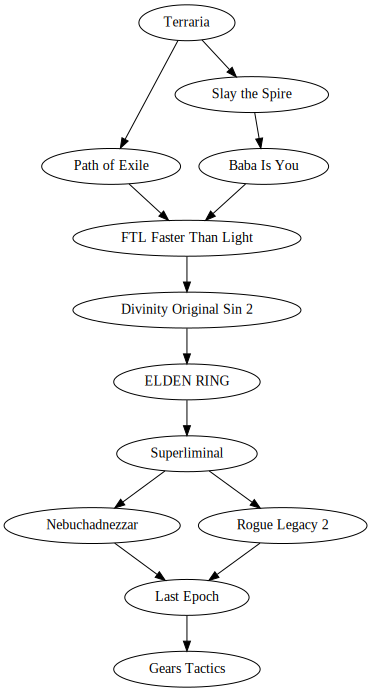

In [13]:
PROMETHEE1_ranking(alternatives, criteria)

In [14]:
def PROMETHEE2_ranking(alternatives: pd.DataFrame, criteria: pd.DataFrame) -> graphviz.Digraph:
    ranking = sorted([(a[1][0], 
                       positive_flow(a, alternatives, criteria)-negative_flow(a, alternatives, criteria))
                       for a in alternatives.iterrows()], 
                       key = lambda x: x[1], reverse=True)
    ranking = [(name, round(score, 2)) for (name, score) in ranking]
    ranking_graph = graphviz.Digraph(comment="PROMETHEE II ranking")
    ranking_graph.node(ranking[0][0], ranking[0][0])
    previous_pair = ranking[0]
    for pair in ranking[1:]:
        ranking_graph.node(pair[0], pair[0])
        ranking_graph.edge(previous_pair[0], pair[0])
        previous_pair = pair
    return ranking_graph

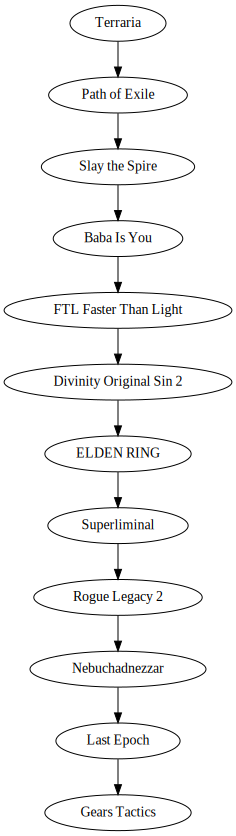

In [15]:
PROMETHEE2_ranking(alternatives, criteria)